In [2]:
import pandas as pd
from pandasql import sqldf
import numpy as np 

In [2]:
# Есть табличка:
# ts — время заказа
# customer_id — айди юзера
# revenue — сумма заказа

# Нужно написать SQL-запрос, который отдаст ARPPU за каждый день (кумулятивно).

In [4]:
user_purchases = pd.DataFrame() # Объявляю основной датафрейм
day_counter = pd.to_datetime('2022-01-01') # Первая дата заказа
end_date = pd.to_datetime('2022-01-31') # Последняя дата заказа
user_id_offset = 100 # Счетчик для имитации притока

In [5]:
# Генерация датафрейма заказов от 1го до 31го января

while day_counter <= end_date:
    all_user_ids = np.arange(1, user_id_offset) # Массив ID пользователей с учетом притока
    daily_purchases_count = np.random.randint(80,120) # Случайное колличество заказов в день
    times = pd.date_range(start = day_counter, periods=24, freq='1H') # Массив возможных значений времени заказа
    
    purchases=np.random.choice(times, daily_purchases_count) # Выбираем случайное время заказа
    user_ids=np.random.choice(all_user_ids, daily_purchases_count) # Выбираем случайныйх пользователей 
    purchase_costs = np.random.uniform(low=1.5, high=100, size=daily_purchases_count) # Выбираем случайныйх пользователей

    day_user_purchases = pd.DataFrame({'ts': purchases, 
                             'customer_id': user_ids, 
                             'revenue': purchase_costs}) #Собираем заказы за день

    user_purchases = user_purchases.append(day_user_purchases, ignore_index=True) # Наполняем основнй датафрейм

  
    user_id_offset += 30 # Счетчик для имитации оттока/притока
    day_counter = day_counter + pd.DateOffset(1) # Переходим к следующему дню

In [6]:
# Сортируем и округляем
user_purchases = user_purchases.sort_values(by = 'ts')
user_purchases['revenue'] = user_purchases['revenue'].round(2)
user_purchases

,ts,customer_id,revenue
88,2022-01-01 00:00:00,58,87.65
21,2022-01-01 00:00:00,48,54.57
35,2022-01-01 00:00:00,60,66.30
64,2022-01-01 00:00:00,1,74.64
74,2022-01-01 00:00:00,1,82.11
...,...,...,...
3147,2022-01-31 22:00:00,154,26.18
3097,2022-01-31 22:00:00,436,12.28
3121,2022-01-31 23:00:00,48,97.11
3128,2022-01-31 23:00:00,200,55.42


In [26]:
# Запрос для оценки общей динамики ARPPU по дням
q = """
with 
active_customers as (
    select b.dt, avg(b.active_customers_cum) as active_customers_cum from (
        select a.dt, count(*) over(order by a.dt) as active_customers_cum from (
            select customer_id, date(min(ts)) as dt from user_purchases
            group by customer_id
        ) a
    ) b
    group by b.dt
),

money as (
        select
            distinct  
                date(ts) as dt,
                sum(revenue) over(order by date(ts)) as revenue_cum
        from user_purchases
)


SELECT
    money.dt,
    revenue_cum / active_customers_cum ARPPU
from money
inner join active_customers on active_customers.dt = money.dt;"""
df_dynamic = sqldf(q)

<AxesSubplot:>

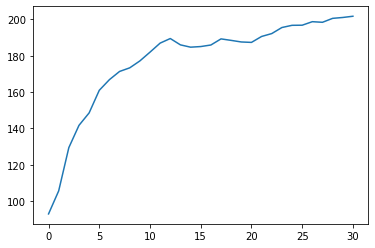

In [27]:
df_dynamic['ARPPU'].plot()

In [30]:
# Запрос для оценки общей динамики ARPPU по дням
q = """
select 
        date(ts) as dt,
        sum(revenue) over(order by date(ts)) as revenue_cum
from user_purchases;"""
sqldf(q)

,dt,revenue_cum
0,2022-01-01,6135.44
1,2022-01-01,6135.44
2,2022-01-01,6135.44
3,2022-01-01,6135.44
4,2022-01-01,6135.44
...,...,...
3162,2022-01-31,158184.16
3163,2022-01-31,158184.16
3164,2022-01-31,158184.16
3165,2022-01-31,158184.16


In [31]:
# Запрос для когортного анализа ARPPU например, по дате первого заказа
q = """SELECT
	date(ts),
	sum (sum(revenue)/(SELECT count(a.customer_id)
	FROM (
		SELECT customer_id, min(date(ts)) as first_purchase from user_purchases GROUP BY customer_id
		) a
	WHERE a.first_purchase = '2022-01-01')) OVER (ORDER BY date(ts)) as ARPPU

FROM user_purchases
WHERE customer_id in (
	SELECT a.customer_id
	FROM (
		SELECT customer_id, min(date(ts)) as first_purchase from user_purchases GROUP BY customer_id
		) a
	WHERE a.first_purchase = '2022-01-01')
GROUP BY date(ts);"""
df_ARPU_cohort = sqldf(q)

<AxesSubplot:>

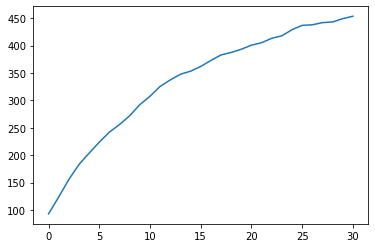

In [32]:
df_ARPU_cohort['ARPPU'].plot()